# Anatomical receptive field analysis

#### Analysis and visualization pipeline:

1. Loading pre- and postsynaptic cell type curated data sets
2. Matching all presynaptic cell ids connecting to each postsynaptic cell
3. Analysis of spatial span of presynaptic inputs to unique postsynaptic cells
4. Plotting value distributions of (3)
5. Colorcoding (3) for every postsynaptic cell column on top of the medulla neuropile mesh
6. Heatmaps of (3) to explore the data and catch some extrem values

In [606]:
#Importing packages

import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import seaborn as sns
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')
from openpyxl import load_workbook
from synapse_queries_helper import combine_xyz
import navis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# For plotting purposes

hemisphere = 'R' # 'R', 'L'
neurpile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L

### 1. Loading curated data sets

In [3]:
#Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230912'
fileName_post = f'Tm9 proofreadings_{date}.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'Dm12 proofreadings_{date}.xlsx'
fileName_pre = f'L3 proofreadings_{date}.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)


In [4]:
# Filtering data

# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == 'R'].copy()
R_post_df = post_df[post_df['hemisphere'] == 'R'].copy()

# Selecting the backbone proofread IDs
#R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()

# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()


In [5]:
# Visualize the final data sets
display(R_post_df.head()) # tail or head is fine
display(R_pre_df.tail()) # tail or head is fine

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),dorso-ventral
691,"182116.0,75129.0,2484.0",Tm9,"170235.0,70370.0,5282.0",strange dendrite,R,Axel Borst Lab,Amalia Braun,"Tm9, Tm9_L, transmedullary neuron Tm9, Choline...",720575940626174522,"Fischbach & Dittrich, 1989",...,NaN,NaN,N,N,N,NaN,NaN,Y,N,V
692,"181221.0,71952.0,2523.0",Tm9,"170742.0,68132.0,5372.0",strange dendrite,R,Axel Borst Lab,Amalia Braun,"Tm9, Tm9_L, transmedullary neuron Tm9, Choline...",720575940630668871,"Fischbach & Dittrich, 1989",...,NaN,NaN,N,N,N,NaN,NaN,Y,N,V
693,"190086.0,85837.0,3281.0",Tm9,"173170.0,78482.0,4592.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940627187849,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,Y,NaN,NaN,Y,N,V
694,"195500.0,50706.0,3987.0",Tm9,"181888.0,53114.0,5025.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940633362131,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,N,NaN,NaN,Y,N,D
695,"195267.0,48669.0,3884.0",Tm9,"181672.0,51656.0,5034.0",NaN,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_L, transmedullary neuron Tm9, FBbt_00...",720575940612657522,"Fischbach & Dittrich, 1989",...,NaN,NaN,Y,N,Y,NaN,NaN,N,N,D


,XYZ-ME,symbol,XYZ-LO,quality comment,rim_area (Y/N),hemisphere,lab,author,name,seg_id,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N)
1145,NaN,L3,NaN,NaN,?,R,NaN,NaN,NaN,720575940622475248,...,L3-R705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1146,NaN,L3,NaN,NaN,?,R,NaN,NaN,NaN,720575940610535410,...,L3-R706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,NaN,L3,NaN,NaN,?,R,NaN,NaN,NaN,720575940630499319,...,L3-R707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1148,NaN,L3,NaN,NaN,?,R,NaN,NaN,NaN,720575940631607291,...,L3-R708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1149,NaN,L3,NaN,NaN,?,R,NaN,NaN,NaN,720575940623327231,...,L3-R709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Matching all presynaptic cell ids connecting to each postsynaptic cell

In [6]:
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = update_df['new_id'].tolist()
    display(update_df[update_df['changed'] == True])
    if len(update_df[update_df['confidence']< 1]) == 0:
        print('Good to go and match ids in the next step')
    else:
        print('Consider updating your ids in the original data set')
else:
    up_to_date_pre_ids = pre_ids
    


Updating:   0%|          | 0/709 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
62,720575940621701313,720575940635116313,0.92,True
365,720575940625026055,720575940615681938,1.00,True
469,720575940620873040,720575940632400971,1.00,True
675,720575940618950557,720575940622238529,0.97,True


Consider updating your ids in the original data set


In [7]:
np.unique(flywire.is_latest_root(pre_ids))[0]

False

In [8]:
## Getting postsynaptic side ID
post_ls = R_post_df['Updated_seg_id'].tolist()

## Getting all synaptic connections

# Quick update
if not np.unique(flywire.is_latest_root(post_ls))[0]: # if not up-to-date
    #Updating the IDs via Fafbseg
    update_df = flywire.update_ids(post_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    post_ls = update_df['new_id']
    display(update_df[update_df['confidence'] < 1])
    

# Fetch the neuron's inputs
post_inputs = flywire.synapses.fetch_synapses(post_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filter connections just selected presynaptic cells
pre_post_match_df = post_inputs[post_inputs['pre'].isin(up_to_date_pre_ids)].copy()
display(pre_post_match_df.head())


Updating:   0%|          | 0/766 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
127,720575940628119548,720575940626856496,0.94,True


Fetching synapses:   0%|          | 0/26 [00:00<?, ?it/s]

,pre,post,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil
28,720575940646547235,720575940642642996,106,821592,290468,169680,821616,290400,169560,3902461,ME_L
39,720575940615151446,720575940659650945,96,778748,362192,168400,778596,362212,168400,4440940,ME_L
143,720575940626136862,720575940625889155,154,796656,281780,136040,796696,281908,136040,34731163,ME_L
267,720575940624649452,720575940630668871,138,723308,286732,95880,723272,286656,95840,10813568,ME_L
273,720575940650823289,720575940634430456,155,833096,239012,208800,833192,238972,208760,11539706,ME_L


### 3. Analysis of spatial span of presynaptic inputs to unique postsynaptic cells

In [9]:
# Aggregating data frame based on unique post and pre segment IDs
# While aggregating, counting the number of contacts for each pre-post pair

pre_post_counts = pre_post_match_df.groupby(['post', 'pre'])['pre'].count().reset_index(name='pre_count')

In [10]:
# Synaptic counts filter (relevant for ur syn >= 3)
min_desired_count = 3
pre_post_counts = pre_post_counts[pre_post_counts['pre_count']>=min_desired_count].copy()
display(pre_post_counts)

,post,pre,pre_count
0,720575940600084489,720575940620369243,39
3,720575940602880736,720575940632981293,35
4,720575940603557920,720575940616803513,32
5,720575940603557920,720575940627317002,3
6,720575940604080318,720575940626822960,31
...,...,...,...
984,720575940659627137,720575940624649452,3
985,720575940659650945,720575940615151446,38
986,720575940659650945,720575940627937301,3
987,720575940659658113,720575940631120384,3


In [236]:
## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
#TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filtering: keeping only synapses in the medulla
pre_inputs = pre_inputs[pre_inputs['neuropil'] == neurpile_mesh].copy()
len(pre_inputs)

Fetching synapses:   0%|          | 0/25 [00:00<?, ?it/s]

438647

In [238]:
#Combining pre- and postsynpases XYZ values in single columns

display(pre_inputs.head()) # Before operation
combine_xyz(pre_inputs) # Function that does the operation
display(pre_inputs.head()) # After operation

,pre,post,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil
0,720575940631893847,720575940630470348,142,753296,175728,160560,753248,175660,160560,138167232,ME_L
3,720575940631893847,720575940630470348,56,753280,175716,160680,753224,175632,160720,138167272,ME_L
12,720575940640304718,720575940622986535,143,757816,347432,135960,757712,347420,135920,32956062,ME_L
13,720575940642535643,720575940635046574,136,719184,364768,133360,719300,364884,133320,94859575,ME_L
37,720575940616945862,720575940607648178,175,819640,212796,215760,819668,212896,215800,17094915,ME_L


,pre_pt_root_id,post_pt_root_id,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil,post_pt_position,pre_pt_position
0,720575940631893847,720575940630470348,142,753296,175728,160560,753248,175660,160560,138167232,ME_L,"[188312.0, 43915.0, 4014.0]","[188324.0, 43932.0, 4014.0]"
3,720575940631893847,720575940630470348,56,753280,175716,160680,753224,175632,160720,138167272,ME_L,"[188306.0, 43908.0, 4018.0]","[188320.0, 43929.0, 4017.0]"
12,720575940640304718,720575940622986535,143,757816,347432,135960,757712,347420,135920,32956062,ME_L,"[189428.0, 86855.0, 3398.0]","[189454.0, 86858.0, 3399.0]"
13,720575940642535643,720575940635046574,136,719184,364768,133360,719300,364884,133320,94859575,ME_L,"[179825.0, 91221.0, 3333.0]","[179796.0, 91192.0, 3334.0]"
37,720575940616945862,720575940607648178,175,819640,212796,215760,819668,212896,215800,17094915,ME_L,"[204917.0, 53224.0, 5395.0]","[204910.0, 53199.0, 5394.0]"


#### Quantification of spatial span

In [607]:
### Quantification of spatial span

# User parameter:
#IMPORTANT NOTE: the current method to filter out points (outliers) is not good enough since it is also discarding good ones
# I NEED something better, an approach based on clustering or Nearest neightbour distance. 
# Thinking in progress...

outliers_threshold = 3  # 2 for method meadian
outliers_method = 'median' # 'mean', 'median'




pre_post_volumes = []
pre_post_areas = []
pre_count = []
pre_xzy_ls = []
post_xzy_ls = []
pre_center_ls = []
num_points = []
for i in range(0,len(post_ls)):

    curr_post = post_ls[i] 
    #display(pre_post_counts[pre_post_counts['post'] == curr_post])
    
    # Getting postynaptic cells coordinates
    old_curr_post = update_df[update_df['new_id'] == curr_post]['old_id'].tolist()[0]
    post_coords = R_post_df[R_post_df['Updated_seg_id'] == old_curr_post]['XYZ-ME'].to_numpy(dtype=str, copy=True)
    post_xyz = np.zeros([np.shape(post_coords)[0],3])
    new_post_coords = np.zeros([np.shape(post_coords)[0],3])
    for idx, coordinate in enumerate(post_coords):
        post_xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
        new_post_coords[idx,:] = np.array([coordinate.split(',')],dtype=float)
    post_xyz *=[4,4,40] # For plotting it using navis (correcting for data resolution)
    post_xzy_ls.append(post_xyz)

    # Getting presynaptic cells coordinates
    curr_pre_ls = pre_post_counts[pre_post_counts['post'] == curr_post]['pre'].tolist() # single postsynaptic neuron candidate
    curr_pre_inputs = pd.DataFrame()
    curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['post_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'post' in the pre_inputs dataframe are our candidate presynapic cells
    curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['pre_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'pre' in the pre_inputs dataframe are our candidate presynapic cells


    if len(curr_pre_inputs) < 10: # if the postsynaptic neuron do not contact any presynaptic one or it has less than 10 synapses
        pre_post_volumes.append(None)
        pre_post_areas.append(None)
        pre_count.append(None)
        pre_xzy_ls.append(None)
        pre_center_ls.append(None)
        num_points.append(None)

    
    else:
        pre_count.append(len(curr_pre_ls))
        # Getting presynaptic cells coordinates
        temp_pre_coords = curr_pre_inputs['pre_pt_position'].tolist()
        
        ## Filtering outliers
        # zscore from scipy (standardizing data and then calculating the score)
        z_scores = np.abs(stats.zscore(temp_pre_coords))
        
        # Manual zscore based on mean
        mean = np.mean(temp_pre_coords, axis=0)
        stddev = np.std(temp_pre_coords, axis=0)
        z_scores_mean = np.abs((temp_pre_coords - mean) / stddev)
        
        # Manual zscore based on median
        median = np.median(temp_pre_coords, axis=0)
        mad = np.median(np.abs(temp_pre_coords - median), axis=0) # Median abosolute deviation

        # Calculate the z-scores using the median and MAD
        z_scores_median = np.abs((temp_pre_coords- median) / mad)
        
#         # Applying outlier filter
#         if outliers_method == 'mean':
#             outlier_indices = np.where(z_scores_mean > outliers_threshold)
#         elif outliers_method == 'median':
#             outlier_indices = np.where(z_scores_median > outliers_threshold)
#         temp_pre_coords = np.delete(temp_pre_coords, outlier_indices, axis=0)
        
        
        # Initialize DBSCAN with appropriate parameters
        eps = 500  # Adjust the neighborhood radius as needed
        min_samples = len(temp_pre_coords) / 5  # Adjust the minimum number of points in a cluster as needed
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Applying DBSCAN filter
        # Fit the DBSCAN model to your data
        dbscan.fit(temp_pre_coords)

        # Find the indices of points that belong to clusters (excluding outliers)
        clustered_indices = np.where(dbscan.labels_ != -1)

        # Convert clustered_indices to a list of integers
        clustered_indices = clustered_indices[0]

        # Filter the points that belong to clusters
        filtered_points = [temp_pre_coords[i] for i in clustered_indices]
        temp_pre_coords = filtered_points # rewritting the variable

        
        # Correcting xyz positions for mesh plotting
        pre_xyz = np.array([list(np.array(l)*[4,4,40]) for l in temp_pre_coords])
        pre_xzy_ls.append(pre_xyz)
        num_points.append(len(pre_xyz)) # Total number of points in the presynaptioc partner(s)
        pre_coords = pre_xyz # Temp (correct)

        # Calculate the center of the cloud of points
        pre_center = np.mean(pre_xyz, axis=0)
        pre_center_ls.append(pre_center)


        # Calculate the volume of the cloud using the convex hull method
        hull = ConvexHull(pre_coords)
        volume = hull.volume
        pre_post_volumes.append(volume)

        #PCA to get an apporximate area of the volume
        # Step 1: Center the data
        mean = np.mean(pre_coords, axis=0)
        centered_points = pre_coords - mean

        # Step 2: Calculate the covariance matrix
        cov_matrix = np.cov(centered_points, rowvar=False)

        # Step 3: Perform PCA to find the normal vector (eigenvector)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        normal_vector = eigenvectors[:, [1, 2]]  # PC2 and PC3
        projected_points = centered_points.dot(normal_vector)

        #Calculate area
        # Calculate the convex hull of the projected points
        hull = ConvexHull(projected_points)

        # Calculate the area of the convex hull
        area = hull.volume  # Area is calculated as volume in 2D
        area_um2 = area / 10**6
        pre_post_areas.append(area_um2)

        # Calculate the vector from the single point to the center of the cloud
        vector_to_center = pre_center - post_xyz
        #vector_to_center *= 10


# Summary data frame
spatial_span_df = pd.DataFrame()
spatial_span_df['bodyId_post'] = post_ls
spatial_span_df['Volume'] = pre_post_volumes
spatial_span_df['Area'] = pre_post_areas
spatial_span_df['Pre_count'] = pre_count
spatial_span_df['Pre_xyz'] = pre_xzy_ls
spatial_span_df['Pre_center'] = pre_center_ls
spatial_span_df['Post_xyz'] = post_xzy_ls
spatial_span_df.set_index('bodyId_post', inplace =True)
spatial_span_df['Area_zscore'] = (spatial_span_df['Area'] - spatial_span_df['Area'].mean()) / spatial_span_df['Area'].std()
spatial_span_df['Num_points'] = num_points

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



IndexError: tuple index out of range

In [610]:
curr_post

720575940623587939

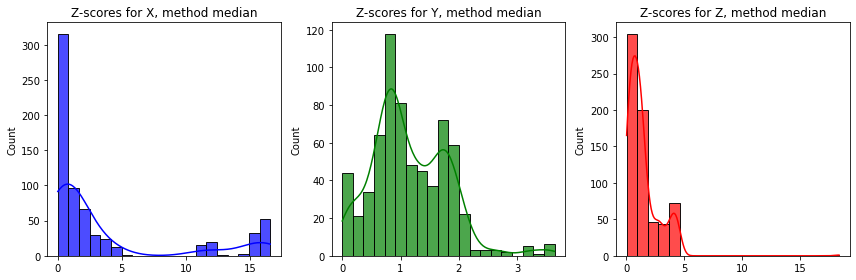

In [433]:
# #Briefly checkin zscore to tune the threshold used above
# Generate example z-scores for X, Y, and Z dimensions
if outliers_method == 'mean':
    z_scores_x = z_scores_mean[:,0]
    z_scores_y = z_scores_mean[:,1]
    z_scores_z = z_scores_mean[:,2]
elif outliers_method == 'median':

    z_scores_x = z_scores_median[:,0]
    z_scores_y = z_scores_median[:,1]
    z_scores_z = z_scores_median[:,2]

# Create subplots for each dimension using Seaborn
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(z_scores_x, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Z-scores for X, method {outliers_method}')

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(z_scores_y, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Z-scores for Y, method {outliers_method}')

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
sns.histplot(z_scores_z, bins=20, color='red', alpha=0.7, kde=True)
plt.title(f'Z-scores for Z, method {outliers_method}')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [434]:
# Quick look into the summary data frame
spatial_span_df.head()


,Volume,Area,Pre_count,Pre_xyz,Pre_center,Post_xyz,Area_zscore,Num_points
bodyId_post,,,,,,,,
720575940626174522,NaN,NaN,NaN,None,None,"[[728464.0, 300516.0, 99360.0]]",NaN,NaN
720575940630668871,2.024601e+11,73.103586,1.0,"[[723072.0, 280212.0, 101400.0], [727520.0, 28...","[723444.2576028622, 286360.56529516994, 100480...","[[724884.0, 287808.0, 100920.0]]",-0.478078,559.0
720575940627187849,2.617072e+11,74.872727,1.0,"[[761048.0, 343160.0, 133760.0], [761840.0, 34...","[758454.2446043165, 342798.23884892085, 130296...","[[760344.0, 343348.0, 131240.0]]",-0.452699,695.0
720575940633362131,3.460342e+11,94.243171,1.0,"[[777288.0, 199112.0, 152880.0], [777712.0, 19...","[781646.7831932773, 202097.6806722689, 152231....","[[782000.0, 202824.0, 159480.0]]",-0.174821,595.0
720575940612657522,4.976880e+11,116.359050,2.0,"[[772296.0, 197824.0, 147760.0], [778872.0, 19...","[778151.5, 195349.15625, 153065.9375]","[[781068.0, 194676.0, 155360.0]]",0.142440,128.0


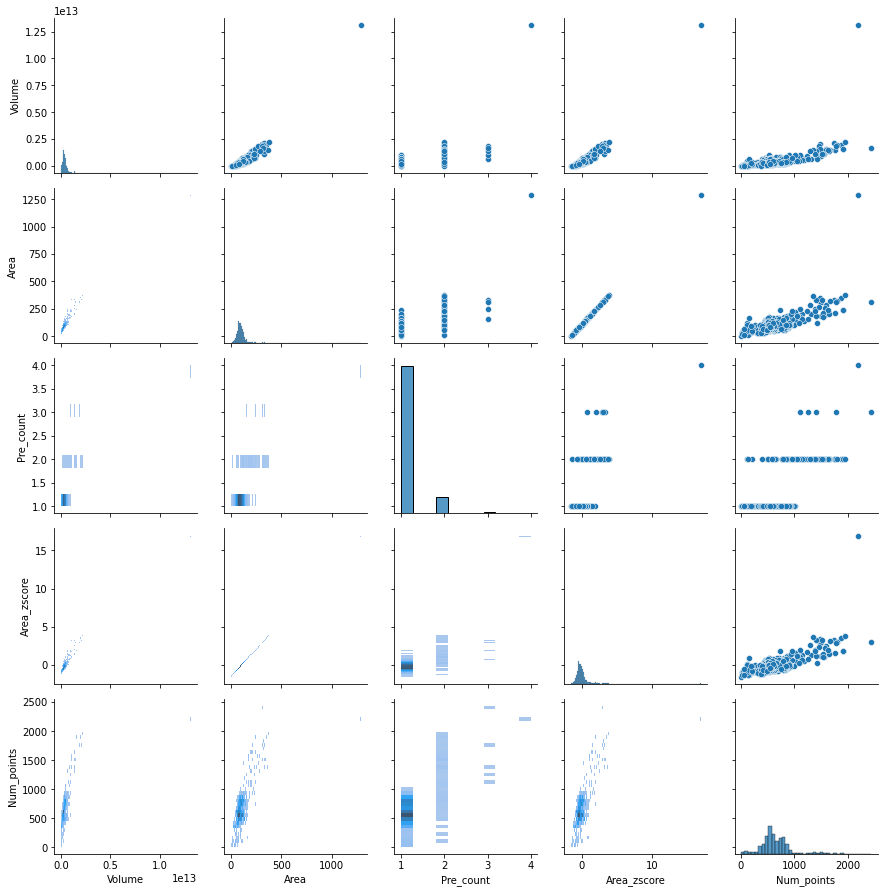

In [435]:
## Brief data visualization with seaborn

# Data
_data = spatial_span_df[spatial_span_df['Pre_count'] == 1].copy()
_data = spatial_span_df.copy()

# Plot
g = sns.PairGrid(_data)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.histplot)

# g.axes[0, 0].set_ylabel("Volume (nm^3)")
# g.axes[1, 0].set_ylabel("Area (um^2)")
# g.axes[2, 0].set_ylabel("Partner count")
# g.axes[2, 0].set_xlabel("Volume (nm^3)")
# g.axes[2, 1].set_xlabel("Area (um^2)")
# g.axes[2, 2].set_xlabel("Partner count")


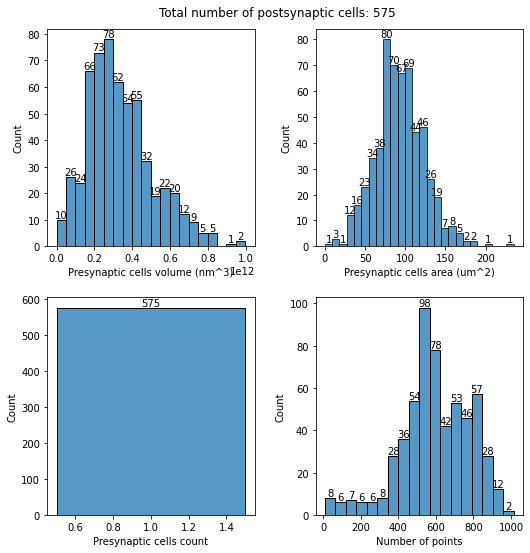

In [564]:
## Brief data distribution visualization adding numbers

# Data
_data = spatial_span_df.copy()
_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner

# Plot
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (20*cm, 20*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Volume'], _data['Area'], _data['Pre_count'],_data['Num_points']]
subplot_labels = ['Presynaptic cells volume (nm^3)', 'Presynaptic cells area (um^2)', 'Presynaptic cells count', 'Number of points']

for i, data in enumerate(histograms):
    sns.histplot(data, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_ylabel('Count')
    axs[i // 2, i % 2].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i // 2, i % 2].patches:
        if p.get_height() > 0:
            axs[i // 2, i % 2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

In [565]:
# TODO, filter data based on an expected minimun of points?
_data['Num_points'].min()

9.0

In [437]:
# Area mean size
_data[_variable].mean() 

93.21408731294915

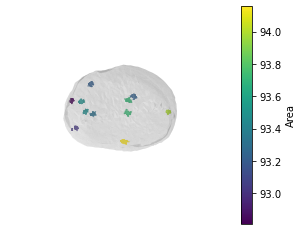

In [507]:
## Visualization of RF size on top of the medulla (color coded)
#%matplotlib notebook
%matplotlib inline
# Data

_variable = 'Area' # 'Area' 'Area_zscore'
_data = spatial_span_df[~np.isnan(spatial_span_df[_variable])] # Filtering out rows with no area
_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner
_data = _data[(_data[_variable] > (_data[_variable].mean() - 1)) & (_data[_variable] < (_data[_variable].mean() + 1))] # Filtering out rows based on area values

# Define a colormap based on the values in _data['Area']
cmap = plt.get_cmap('viridis')  # You can choose any other colormap

# Normalize the Area values to map them to the colormap
normalize = plt.Normalize(vmin=_data[_variable].min(), vmax=_data[_variable].max())

# Plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for _area, post_id in zip(_data[_variable].tolist(), _data[_variable].index.tolist()):
    curr_pre_coords = _data.loc[[post_id]]['Pre_xyz'].tolist()[0]
    
    # Map the Area value to a color from the colormap
    _color = cmap(normalize(_area))
    
    ax.scatter(curr_pre_coords[:, 0], curr_pre_coords[:, 1], curr_pre_coords[:, 2], '.', color=_color, s=0.1)

# Create a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])  # An empty array is sufficient
cbar = plt.colorbar(sm, label= f'{_variable}')
 

OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

ax.azim = mesh_azim
ax.elev = mesh_elev





In [439]:
import plotly.graph_objects as go

# Create an empty figure
fig = go.Figure()

# Define the marker size (adjust this value as needed)
marker_size = 2  # Change this value to your desired marker size


for _area, post_id in zip(_data[_variable].tolist(), _data[_variable].index.tolist()):
    curr_pre_coords = _data.loc[[post_id]]['Pre_xyz'].tolist()[0]
    
    # Map the Area value to a normalized value
    _normalized_area = normalize(_area)

    trace = go.Scatter3d(
        x=curr_pre_coords[:, 0],
        y=curr_pre_coords[:, 1],
        z=curr_pre_coords[:, 2],
        mode='lines+markers',  # Combine lines and markers
        marker=dict(size=marker_size),
        line=dict(width=2)  
    )
    fig.add_trace(trace)

# Show the figure
fig.show()

In [514]:
post_list = _data.index.tolist()
pre_post_counts[pre_post_counts['post'].isin(post_list)]

,post,pre,pre_count
140,720575940614212754,720575940627832392,34
201,720575940616954297,720575940627832392,3
415,720575940623115213,720575940631324175,33
506,720575940625188042,720575940632748883,14
532,720575940626010652,720575940631433027,32
614,720575940627990020,720575940629535217,33
714,720575940631225943,720575940625955646,30
763,720575940632916783,720575940620910612,42
862,720575940637834867,720575940624874727,34
866,720575940637942837,720575940625315709,27


In [613]:
# Single case to debug

#i = 26
#curr_post = post_ls[i] 
outliers_threshold = 2  # Adjust this threshold as needed
curr_post = 720575940623587939# 720575940637942837
#display(pre_post_counts[pre_post_counts['post'] == curr_post])



# Getting presynaptic cells coordinates
curr_pre_ls = pre_post_counts[pre_post_counts['post'] == curr_post]['pre'].tolist() # single postsynaptic neuron candidate
curr_pre_inputs = pd.DataFrame()
curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['post_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'post' in the pre_inputs dataframe are our candidate presynapic cells
curr_pre_inputs = curr_pre_inputs.append(pre_inputs[pre_inputs['pre_pt_root_id'].isin(curr_pre_ls)].copy()) # here 'pre' in the 
pre_coords = curr_pre_inputs['pre_pt_position'].tolist()

## Filtering outliers
# zscore from scipy (standardizing data and then calculating the score)
z_scores = np.abs(stats.zscore(pre_coords))
        
# Manual zscore based on mean
mean = np.mean(pre_coords, axis=0)
stddev = np.std(pre_coords, axis=0)
z_scores_mean = np.abs((pre_coords - mean) / stddev)
        
# Manual zscore based on median
median = np.median(pre_coords, axis=0)
mad = np.median(np.abs(pre_coords - median), axis=0) # Median abosolute deviation

# Calculate the z-scores using the median and MAD
z_scores_median = np.abs((pre_coords- median) / mad)

# # Applying outlier filter
# outlier_indices = np.where(z_scores_median > outliers_threshold)
# pre_coords = np.delete(pre_coords, outlier_indices, axis=0)

# Initialize DBSCAN with appropriate parameters
eps = 500  # Adjust the neighborhood radius as needed
min_samples = round(len(pre_coords) / 5)  # Adjust the minimum number of points in a cluster as needed
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Applying DBSCAN filter
# Fit the DBSCAN model to your data
dbscan.fit(pre_coords)

# Find the indices of points that belong to clusters (excluding outliers)
clustered_indices = np.where(dbscan.labels_ != -1)

# Convert clustered_indices to a list of integers
clustered_indices = clustered_indices[0]

# Filter the points that belong to clusters
filtered_points = [pre_coords[i] for i in clustered_indices]
#pre_coords = filtered_points # rewritting the variable



pre_xyz = np.array([list(np.array(l)*[4,4,40]) for l in pre_coords])
pre_coords = pre_xyz # Temp (correct)

# Calculate the center of the cloud of points
pre_center = np.mean(pre_coords, axis=0)

# Calculate the volume of the cloud using the convex hull method
from scipy.spatial import ConvexHull
hull = ConvexHull(pre_coords)
volume = hull.volume

#PCA to get an apporximate area of the volume
# Step 1: Center the data
mean = np.mean(pre_coords, axis=0)
centered_points = pre_coords - mean

# Step 2: Calculate the covariance matrix
cov_matrix = np.cov(centered_points, rowvar=False)

# Step 3: Perform PCA to find the normal vector (eigenvector)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
normal_vector = eigenvectors[:, [1, 2]]  # PC2 and PC3
projected_points = centered_points.dot(normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6


# Getting postynaptic cells coordinates
old_curr_post = update_df[update_df['new_id'] == curr_post]['old_id'].tolist()[0]
post_coords = R_post_df[R_post_df['Updated_seg_id'] == old_curr_post]['XYZ-ME'].to_numpy(dtype=str, copy=True)
post_xyz = np.zeros([np.shape(post_coords)[0],3])
new_post_coords = np.zeros([np.shape(post_coords)[0],3])
for idx, coordinate in enumerate(post_coords):
    post_xyz[idx,:] = np.array([coordinate.split(',')],dtype=float)
    new_post_coords[idx,:] = np.array([coordinate.split(',')],dtype=float)
post_xyz *=[4,4,40] # For plotting it using navis

# Calculate the vector from the single point to the center of the cloud
vector_to_center = pre_center - post_xyz
#vector_to_center *= 10

In [621]:
np.where(dbscan.labels_ != -1)

(array([], dtype=int64),)

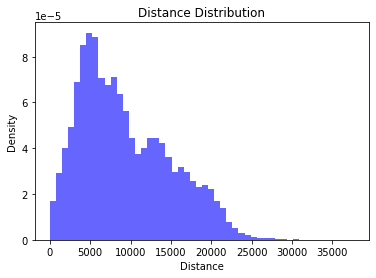

In [620]:
# For eps parameter adjustments

# Calculate pairwise distances
distances = []
for i in range(len(pre_coords)):
    for j in range(i+1, len(pre_coords)):
        distance = np.linalg.norm(pre_coords[i] - pre_coords[j])
        distances.append(distance)

# Create a histogram or KDE plot of distances
plt.hist(distances, bins=50, density=True, alpha=0.6, color='b')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Distance Distribution')
plt.show()

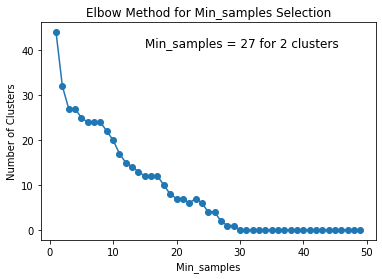

In [597]:
desired_num_clusters = 2  # Replace with your desired number of clusters

# For min_samples parameter adjustments
# Create an array of min_samples values to test
min_samples_values = range(1, 50)
num_clusters = []

for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=500, min_samples=min_samples)
    dbscan.fit(pre_coords)
    num_clusters.append(len(set(dbscan.labels_)) - 1)  # Subtract 1 to account for noise points

# Find the min_samples value that gives the desired number of clusters
selected_min_samples = None
for min_samples, num_cluster in zip(min_samples_values, num_clusters):
    if num_cluster == desired_num_clusters:
        selected_min_samples = min_samples
        break

# Plot the number of clusters vs. min_samples
plt.plot(min_samples_values, num_clusters, marker='o')
plt.xlabel('Min_samples')
plt.ylabel('Number of Clusters')
plt.title('Elbow Method for Min_samples Selection')

# Label the plot with the selected min_samples value
if selected_min_samples is not None:
    plt.text(15, 40, f'Min_samples = {selected_min_samples} for {desired_num_clusters} clusters', fontsize=12, verticalalignment='bottom')

plt.show()

In [598]:
# Trying PCA to get a 2D plane for the 3D cloud of points:

# Step 1: Center the data
mean = np.mean(pre_coords, axis=0)
centered_points = pre_coords - mean

# Step 2: Calculate the covariance matrix
cov_matrix = np.cov(centered_points, rowvar=False)

# Step 3: Perform PCA to find the normal vector (eigenvector)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
normal_vector = eigenvectors[:, 0]  # Smallest eigenvalue corresponds to the normal vector

# Step 4: Project points onto the plane
projected_points = centered_points - np.outer(centered_points.dot(normal_vector), normal_vector)
                                              
                                    

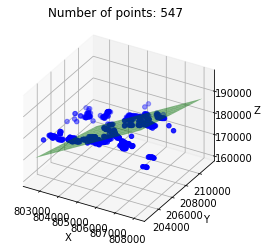

In [599]:
# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

# Plot the original 3D points
ax.scatter(pre_coords[:, 0], pre_coords[:, 1], pre_coords[:, 2], marker='o', label='Original Points', c='blue')

# Plot the plane
d = -mean.dot(normal_vector)  # Calculate the constant in the plane equation
xx, yy = np.meshgrid(np.linspace(np.min(pre_coords[:, 0]), np.max(pre_coords[:, 0]), 10),
                     np.linspace(np.min(pre_coords[:, 1]), np.max(pre_coords[:, 1]), 10))
zz = (-normal_vector[0] * xx - normal_vector[1] * yy - d) / normal_vector[2]
ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')


# Show the 3D plot
plt.show()         

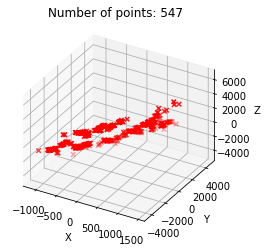

In [600]:
# Create a 3D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')


# Plot the projected points onto the plane
ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], marker='x', label='Projected Points', c='red')


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Number of points: {len(pre_coords)}')


# Show the 3D plot
plt.show()         

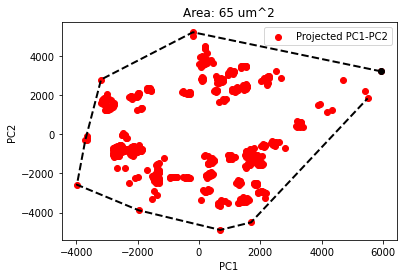

In [601]:
# Create a 2D scatter plot for PCA-based projection

normal_vector = eigenvectors[:, [1, 2]]  # PC2 and PC3
projected_points = centered_points.dot(normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the PC1 and PC2 components
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='o', label='Projected PC1-PC2', c='red')

plt.plot(projected_points[hull.vertices,0], projected_points[hull.vertices,1], 'k--', lw=2)
plt.plot(projected_points[hull.vertices[0],0], projected_points[hull.vertices[0],1], 'ko')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Area: {round(area_um2)} um^2')

# Show the plot
plt.legend()
plt.show()

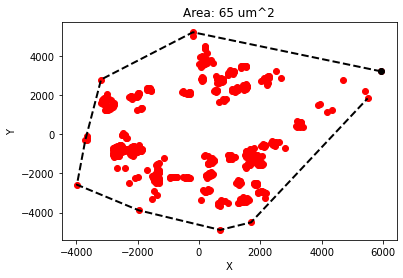

In [602]:
# Create a 2D scatter plot for brute force projection
fig = plt.figure()

# Extract the 2D coordinates
projected_2d = projected_points[:, [0, 1]]  # Assuming you want the first two dimensions

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the 2D coordinates
plt.scatter(projected_2d[:, 0], projected_2d[:, 1], marker='o', label='Projected 2D Points', c='red')

plt.plot(projected_2d[hull.vertices,0], projected_2d[hull.vertices,1], 'k--', lw=2)
plt.plot(projected_2d[hull.vertices[0],0], projected_2d[hull.vertices[0],1], 'ko')



plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Area: {round(area_um2)} um^2')

plt.show()    

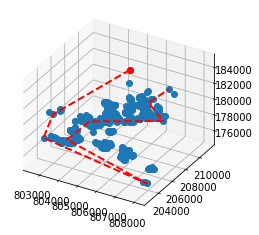

In [603]:
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o')
ax.plot(pre_coords[hull.vertices,0], pre_coords[hull.vertices,1], pre_coords[hull.vertices,2], 'r--', lw=2)
ax.plot(pre_coords[hull.vertices[0],0], pre_coords[hull.vertices[0],1],pre_coords[hull.vertices[0],2], 'ro')

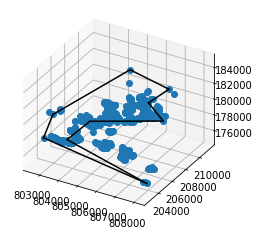

In [604]:
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o')
for simplex in hull.simplices:
    ax.plot(pre_coords[simplex, 0], pre_coords[simplex, 1], pre_coords[simplex, 2], 'k-')

Text(0.5, 0.92, '3D Plot with Volume Information')

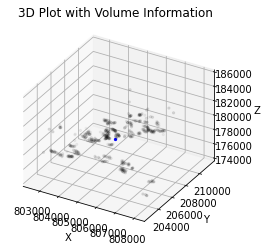

In [605]:
# Brief visualization of points
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
#ax.scatter(new_post_coords[:,0],new_post_coords[:,1],new_post_coords[:,2],'.',color=[1,0,0], s = 5) # Location of postsynaptic cell
ax.scatter(pre_center[0],pre_center[1],pre_center[2],'.',color=[0,0,1], s = 5) # Location of center of cloud of presynaptic cells
ax.scatter(pre_coords[:,0],pre_coords[:,1],pre_coords[:,2],'.',color=[0,0,0,0.1], s = 5) # Cloud


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot with Volume Information')

# # Plot the vector as an arrow
# ax.quiver(post_xyz[0, 0], post_xyz[0, 1], post_xyz[0, 2],
#           vector_to_center[:,0], vector_to_center[:,1], vector_to_center[:,2],
#           color='g', label='Vector to Center')



# OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) 
# navis.plot2d([OL_R], method='3d_complex', ax=ax) # scalebar = '20 um'

# ax.azim = mesh_azim
# ax.elev = mesh_elev

# Code on porgress or old tests


#### Attemps to project the 3D cloud into a 2D plane.

In [252]:
## Projecting to a 2D plane

# Normalize the vector_to_center to define the normal vector of the plane
normal_vector = vector_to_center / np.linalg.norm(vector_to_center)

# Calculate the projection of all cloud points onto the plane
projections = np.dot(pre_xyz - post_xyz, np.squeeze(normal_vector))

# Calculate the projected points
projected_pre_xyz = pre_xyz - projections[:, np.newaxis] * normal_vector

# Calculate the projection of the center onto the plane
projected_pre_center = pre_center - np.dot(pre_center - post_xyz, np.squeeze(normal_vector)) * normal_vector

# Calculate the projection of the postsynaptic cell
projected_post_xyz = post_xyz - np.dot(post_xyz - post_xyz, np.squeeze(normal_vector)) * normal_vector

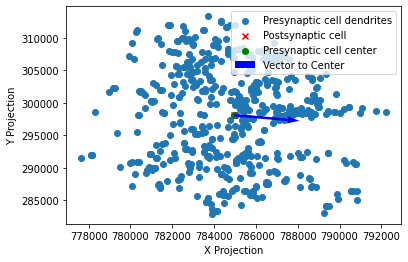

In [253]:
# Create a 2D scatter plot of the projected points
plt.scatter(projected_pre_xyz[:, 0], projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projected_post_xyz[:, 0], projected_post_xyz[:,1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projected_pre_center[:,0], projected_pre_center[:,1], c='g', marker='o', label='Presynaptic cell center')

# Plot the vector_to_center as an arrow
plt.quiver(projected_post_xyz[:,0], projected_post_xyz[:,1],
           vector_to_center[:,0], vector_to_center[:,1],
           angles='xy', scale_units='xy', scale=1, color='b', label='Vector to Center')

# Set axis labels
plt.xlabel('X Projection')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

ValueError: x and y must be the same size

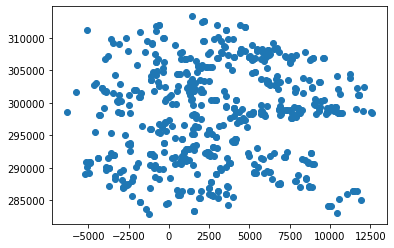

In [254]:
## Testing another plane:

# Calculate the new 2D plane's normal vector
new_normal_vector = np.array([1.0, 0.0, 0.0])  # Example: A plane perpendicular to the X-axis

# Calculate the projection of the points onto the new 2D plane
projection_magnitude = np.dot(pre_xyz - post_xyz, new_normal_vector)

# Create a 2D scatter plot of the projected points onto the new 2D plane
plt.scatter(projection_magnitude, projected_pre_xyz[:, 1], label='Presynaptic cell dendrites')
plt.scatter(projection_magnitude, projected_post_xyz[:, 1], c='r', marker='x', label='Postsynaptic cell')
plt.scatter(projection_magnitude, projected_pre_center[:, 1], c='g', marker='o', label='Presynaptic cell center')

# Plot the projection of the vector_to_center as a single dot in the new 2D plane
plt.scatter(0, 0, c='b', marker='o', label='Projected Vector to Center')

# Set axis labels
plt.xlabel('X Projection (New Plane)')
plt.ylabel('Y Projection')

# Set legend
plt.legend()

# Show the plot
plt.show()

In [184]:
volume



8214102759039.997

In [189]:
vector_to_center[:,0]

array([-6951.69191919])

In [ ]:
navis.plot3d([pre_xyz], color= [1,0,0]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]
navis.plot3d([OL_R], color= [0.5,0.5,0.5,0.1]) # [0.5,0.5,0.5,0.1],[1,1,0],[1,0,1]]